In [1]:
import torch 
from models import NONA_FT, NONA
from similarity_masks import SoftKNNMask, SoftPointwiseKNN, LnSmoothStep
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from transformers import AutoTokenizer, AutoModel
from ft_cnn import RSNADataset
from ft_transformer import AdressoDataset
from utils import load_data_params, get_folds
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torcheval.metrics.functional import mean_squared_error
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import sys
import pickle as pkl

/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cpu')
path = 'results/rsna/models/04052118/nona l2_0.pth'
path_split = path.split('/')
dataset = path_split[1]
model_type = path_split[-1][:-6]
run = path_split[-2]
seed = int(path_split[-1][-5])

label = None
if len(path_split) == 6:
    label = path_split[2]

pred_sim = model_type.split(" ")
if len(pred_sim)==2:
    predictor_head = pred_sim[0]
    sim = pred_sim[1]
else:
    predictor_head = model_type 
    sim = None

if dataset in ['rsna', 'cifar']:
    feature_extractor_weights = resnet18(weights='DEFAULT')
elif dataset == 'adresso':
    feature_extractor_weights = AutoModel.from_pretrained("distilbert-base-uncased")

mc = 10 if dataset=='cifar' else None
hls = [200, 50]
mask = LnSmoothStep()
model = NONA_FT(feature_extractor=feature_extractor_weights, 
                hl_sizes=hls, 
                predictor=predictor_head, 
                similarity=sim, 
                mask=mask,
                multiclass=mc,
                dtype=torch.float32
                )

In [5]:
sft_weights = torch.load(path, map_location=device)
model.load_state_dict(sft_weights)

<All keys matched successfully>

In [6]:
if dataset == 'rsna':
    task, fe = load_data_params(dataset)
    idx_dict = get_folds(dataset=dataset, seed=seed)
elif dataset == 'adresso':
    task, data_df, fe, tokenizer = load_data_params(dataset, label=label)
    idx_dict = get_folds(dataset=dataset, label=label, seed=seed)

elif dataset == 'cifar':
    task, fe = load_data_params(dataset)
    idx_dict = get_folds(dataset=dataset, seed=seed)

In [7]:
def img_collate(batch):
    x, y = zip(*batch)
    x = torch.stack(x).to(device).to(torch.float32)
    y = torch.tensor(y, dtype=torch.float32, device=device)
    return x, y

def txt_collate(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.float)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

if dataset == 'rsna':
    train_dataset = RSNADataset(idx_dict['train'])
    train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=img_collate)

    test_dataset = RSNADataset(idx_dict['test'])
    test_loader = DataLoader(test_dataset, batch_size=128, collate_fn=img_collate)

elif dataset == 'adresso':
    train_dataset = AdressoDataset(label=label, tokenizer=tokenizer, ids=idx_dict['train'])
    train_loader = DataLoader(train_dataset.get_dataset(), batch_size=train_dataset.len(), collate_fn=txt_collate) # for use as neighbors with val and test

    val_dataset = AdressoDataset(label=label, tokenizer=tokenizer, ids=idx_dict['val'], scaler=train_dataset.scaler)
    val_loader = DataLoader(val_dataset.get_dataset(), batch_size=val_dataset.len(), collate_fn=txt_collate)

    test_dataset = AdressoDataset(label=label, tokenizer=tokenizer, scaler=train_dataset.scaler)
    test_loader = DataLoader(test_dataset.get_dataset(), batch_size=test_dataset.len(), collate_fn=txt_collate)

elif dataset == 'cifar':
    train_loader = DataLoader(idx_dict['train'], batch_size=128, collate_fn=img_collate)
    val_loader = DataLoader(idx_dict['val'], batch_size=128, collate_fn=img_collate)
    test_loader = DataLoader(idx_dict['test'], batch_size=128, collate_fn=img_collate)

In [8]:
if dataset in ['rsna', 'cifar']:
    z_train = []
    y_train = []
    z_test = []
    y_test = []
    with torch.no_grad():
        for X, y in tqdm(train_loader, desc='Train'):
            y_train.append(y)
            _, z, _ = model(X,X[:2], y[:2], get_embeddings=True)
            z_train.append(z)
        
        for X, y in tqdm(test_loader, desc='Test'):
            y_test.append(y)
            _, z, _ = model(X,X[:2], y[:2], get_embeddings=True)
            z_test.append(z)
    
    z_train = torch.cat(z_train, dim=0)
    y_train = torch.cat(y_train, dim=0)
    z_test = torch.cat(z_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

    y_hat_train = model.nona.output_layer(z_train, z_train, y_train)
    y_hat_test = model.nona.output_layer(z_test, z_train, y_train)

    if y_hat_test.dim() == 2:
        y_hat_test = torch.argmax(y_hat_test, dim=1)
        y_hat_train = torch.argmax(y_hat_train, dim=1)

elif dataset == 'adresso':
    with torch.no_grad():
        for train_batch, test_batch in zip(train_loader, test_loader):
            X_train = {key: val.to(device) for key, val in train_batch.items() if key!='labels'}
            y_train = train_batch['labels'].to(device)
            
            X_test = {key: val.to(device) for key, val in test_batch.items() if key!='labels'}
            y_test = test_batch['labels'].to(device)
            
            y_hat_test, z_test, z_train = model(X_test, X_train, y_train, get_embeddings=True)

            if predictor_head == 'dense' and label == 'dx':
                y_hat_train = y_hat_train.sigmoid()
                y_hat_test = y_hat_test.sigmoid()

Test: 100%|██████████| 22/22 [06:49<00:00, 18.62s/it]


In [12]:
if dataset in ['rsna', 'cifar']:
    results_path = f"results/{dataset}/scores_{run}.pkl"
elif dataset == 'adresso':
    results_path = f"results/{dataset}/{label}/scores_{run}.pkl"

with open(results_path, "rb") as file:
    results = pkl.load(file=file)
    desc = results[0]
    scores_list = results[1:]
print(desc)

test_score = abs(scores_list[seed][f'{model_type} mlp'][0])

LnSmoothStep


In [9]:
test_score = mean_squared_error(y_hat_test, y_test)

In [ ]:
proj_dim = 2

embedding_set = 'train'
if embedding_set == 'train':
    embeddings = z_train
    label_dict = {'y_true': y_train, 'y_hat': y_hat_train, 'squared error': (y_hat_train - y_train)**2}    
elif embedding_set == 'test':
    embeddings = z_test
    label_dict = {'y_true': y_test, 'y_hat': y_hat_test, 'squared error': (y_hat_test - y_test)**2}
elif embedding_set == 'all':
    embeddings = torch.cat([z_train, z_test])
    label_dict = {'y_true': torch.cat([y_train, y_test]), 'y_hat': torch.cat([y_hat_train, y_hat_test]), 'squared error': (torch.cat([y_hat_train, y_hat_test]) - torch.cat([y_train, y_test]))**2}

proj_type = 'umap'
if proj_type == 'tsne':
    proj = TSNE(n_components=proj_dim, random_state=42)
elif proj_type == 'pca':
    proj = PCA(n_components=proj_dim, random_state=42)
elif proj_type == 'umap':
    proj = UMAP(n_components=proj_dim, random_state=42)

z_proj = proj.fit_transform(embeddings)

for label_to_vis, y in label_dict.items():
    
    title = f"{proj_type.upper()} of {model_type} embeddings colored by {label_to_vis} \n test score = {test_score : 4f}"

    colors = 'tab10' if dataset=='cifar' else 'viridis'
    
    fig = plt.figure(figsize=(8, 6))#, dpi=200)
    if proj_dim == 2:
        plt.scatter(z_proj[:, 0], z_proj[:, 1], c=y, cmap=colors, alpha=0.7)
        plt.colorbar(label=label_to_vis)
        plt.title(title)

    elif proj_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(z_proj[:, 0], z_proj[:, 1], z_proj[:, 2], c=y, cmap=colors, alpha=0.7)
        fig.colorbar(ax.scatter(z_proj[:, 0], z_proj[:, 1], z_proj[:, 2], c=y, cmap=colors, alpha=0.7), label=label_to_vis)
        ax.set_title(title)
    
    if embedding_set == 'all':
        for i in range(-len(y_test), 0):
            plt.text(z_proj[i, 0], z_proj[i, 1], '*', fontsize=2, ha='center', va='center', color='black')
            
    plt.show()

/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/sc/arion/projects/pandeg01a/susmaa01/nona/.venv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


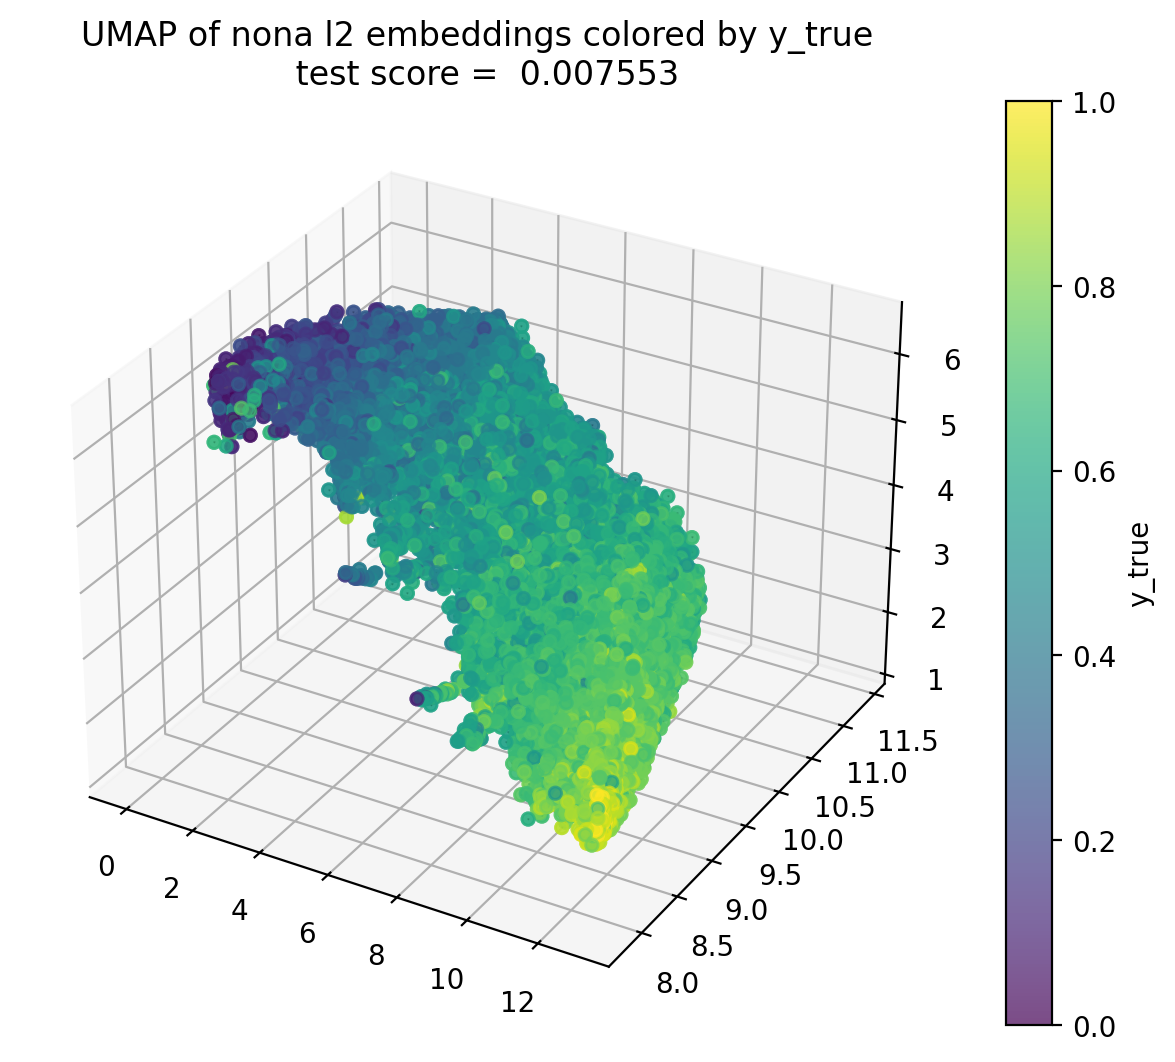

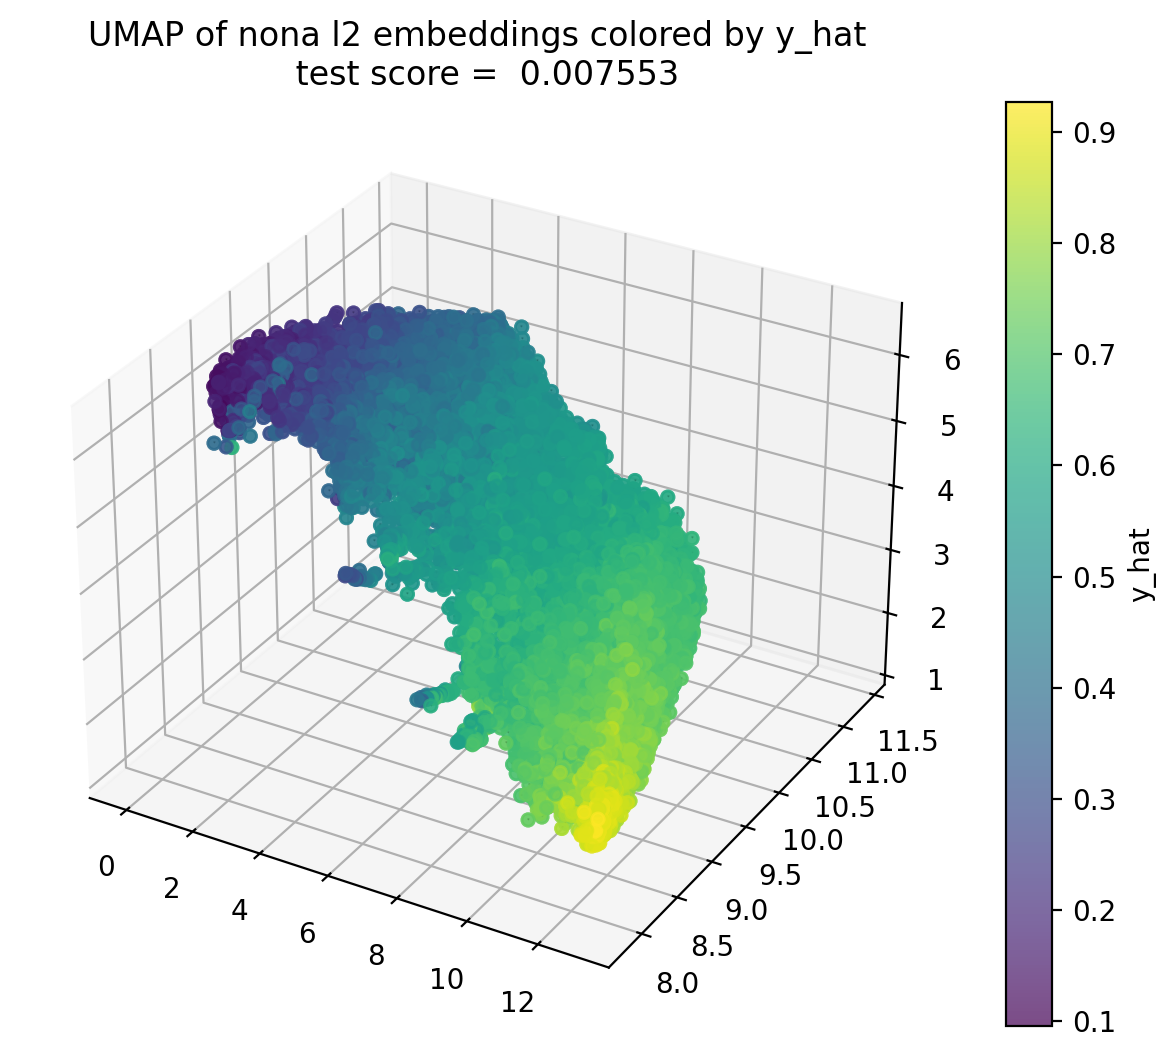

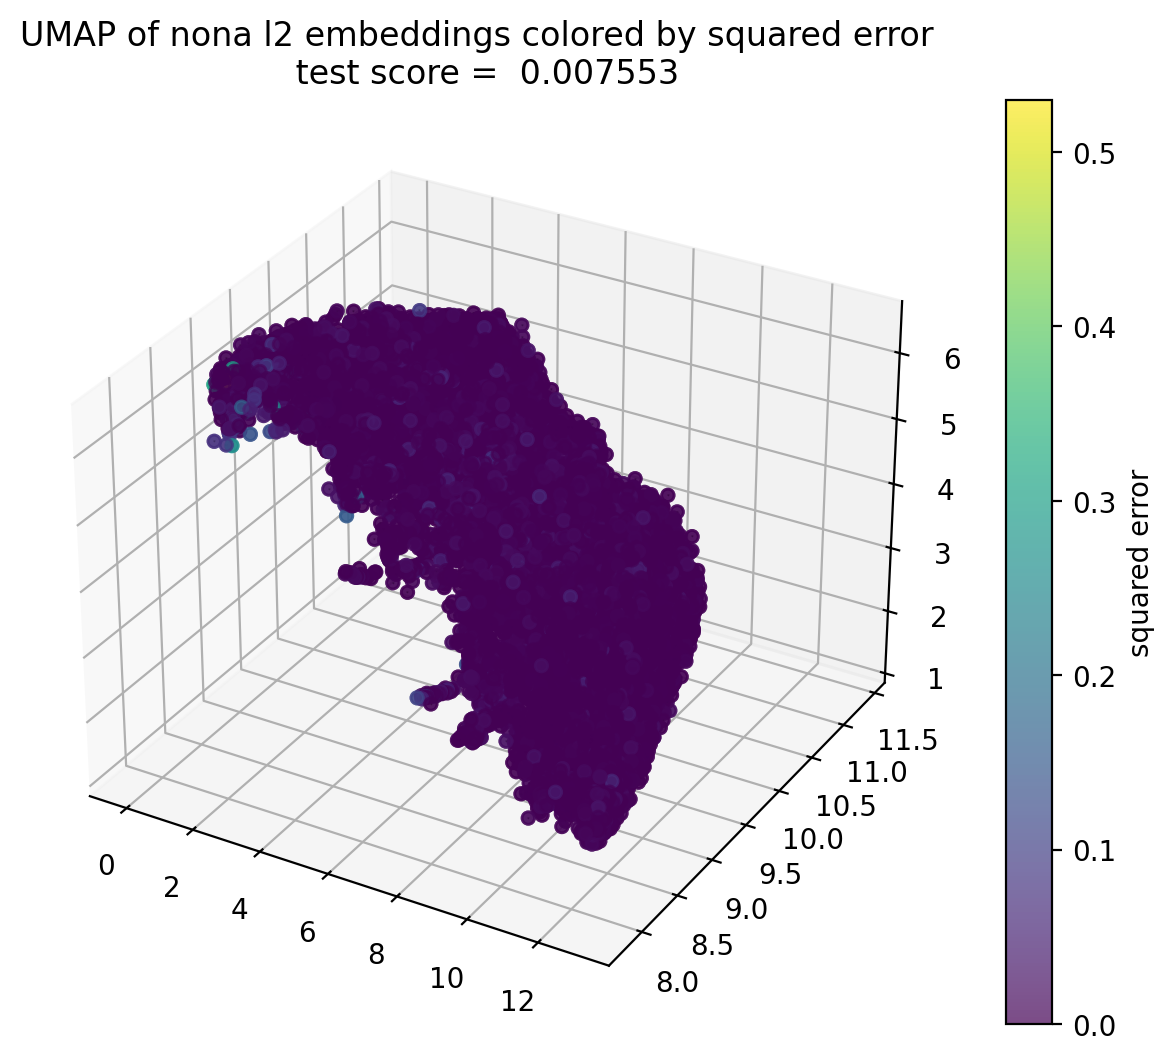

In [11]:
'''
Fit a projection with z_train, and then transform z_test
'''
proj_dim=3
proj_type = 'umap'
if proj_type == 'tsne':
    proj = TSNE(n_components=proj_dim, random_state=42)
elif proj_type == 'pca':
    proj = PCA(n_components=proj_dim, random_state=42)
elif proj_type == 'umap':
    proj = UMAP(n_components=proj_dim, random_state=42)

proj_z_train = proj.fit_transform(z_train)
proj_z_test = proj.transform(z_test)

z_proj = np.concat([proj_z_train, proj_z_test])

label_dict = {'y_true': torch.cat([y_train, y_test]), 'y_hat': torch.cat([y_hat_train, y_hat_test]), 'squared error': (torch.cat([y_hat_train, y_hat_test]) - torch.cat([y_train, y_test]))**2}

for label_to_vis, y in label_dict.items():
    
    title = f"{proj_type.upper()} of {model_type} embeddings colored by {label_to_vis} \n test score = {test_score : 4f}"

    colors = 'tab10' if dataset=='cifar' else 'viridis'
    
    fig = plt.figure(figsize=(8, 6), dpi=200)
    if proj_dim == 2:
        plt.scatter(z_proj[:, 0], z_proj[:, 1], c=y.detach(), cmap=colors, alpha=0.7)
        plt.colorbar(label=label_to_vis)
        plt.title(title)

    elif proj_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(z_proj[:, 0], z_proj[:, 1], z_proj[:, 2], c=y.detach(), cmap=colors, alpha=0.7)
        fig.colorbar(ax.scatter(z_proj[:, 0], z_proj[:, 1], z_proj[:, 2], c=y.detach(), cmap=colors, alpha=0.7), label=label_to_vis)
        ax.set_title(title)
    
    for i in range(-len(y_test), 0):
        if proj_dim == 2:
            plt.text(z_proj[i, 0], z_proj[i, 1], '*', fontsize=2, ha='center', va='center', color='black')
        elif proj_dim == 3:
            ax.text(z_proj[i, 0], z_proj[i, 1], z_proj[i, 2], '*', fontsize=2, ha='center', va='center', color='black')
            
    plt.show()

In [26]:
min(y_hat_test.min(),y_hat_train.min())

tensor(0.1341, grad_fn=<MinBackward1>)

In [20]:
# # Not the same as above. Outputs from above are with 50d NONA

# nona = NONA(dtype=torch.float32)
# grid_size = 500
# scale = 40

# x_grid = torch.linspace(-scale, scale, grid_size).to(torch.float32)
# y_grid = torch.linspace(-scale, scale, grid_size).to(torch.float32)

# X_test = torch.cartesian_prod(x_grid, y_grid)

# Z = nona(X_test, torch.tensor(z_proj), y_train).reshape(grid_size,grid_size).detach()

# X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# fig = plt.figure()
# ax = plt.axes(projection ='3d')
# ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

In [21]:
# xx, yy = np.meshgrid(np.linspace(-scale, scale, grid_size), np.linspace(-scale, scale, grid_size))
# grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# probabilities = nona(grid_points,  torch.tensor(z_proj), y_train).reshape(grid_size, grid_size).detach()

# # Plot the heatmap using contourf
# plt.figure(figsize=(8, 6))
# plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# plt.show()